In [1]:
!git clone https://github.com/karencfisher/GAN-experiments.git
%cd GAN-experiments

fatal: destination path 'GAN-experiments' already exists and is not an empty directory.
/content/GAN-experiments


In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm

from utils import view_samples
from training import train_discriminator, train_generator, make_samples

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train = datasets.CIFAR10(root='data/', download=True, transform=transform)

batch_size = 128
num_workers = 4

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


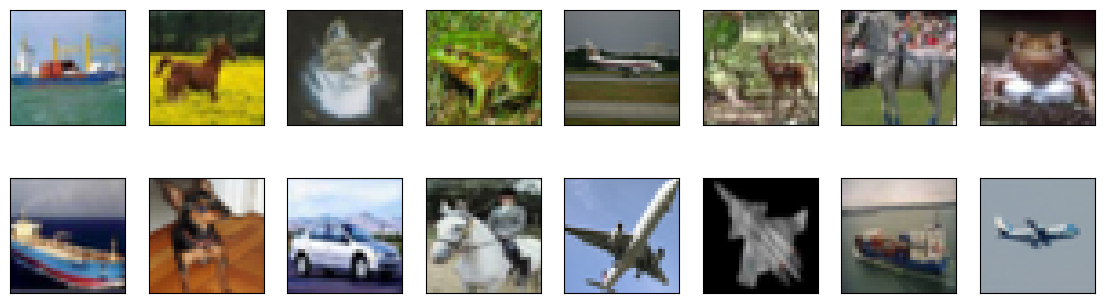

In [14]:
images, _ = next(iter(train_loader))
view_samples(images[:16])

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_batch_norm=True):
        super(ConvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2,
                              padding = 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)


class Discriminator(nn.Module):
    def __init__(self, conv_dim=64, channels=3):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            ConvBlock(channels, conv_dim, 4, use_batch_norm=False),
            ConvBlock(conv_dim, conv_dim * 2, 4),
            ConvBlock(conv_dim * 2, conv_dim * 4, 4),
            ConvBlock(conv_dim * 4, conv_dim * 8, 4), # This layer means output is 2x2

            nn.Flatten(),
            nn.Linear(conv_dim * 8 * 2 * 2, 1) # Calculation is for 2x2 output from last ConvBlock
        )

    def forward(self, x):
        return self.discriminator(x)

In [5]:
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, use_batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, conv_dim=64, channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            DeconvBlock(latent_dim, conv_dim * 4, 4, 1, 0),  # 1x1 -> 4x4
            DeconvBlock(conv_dim * 4, conv_dim * 2, 4, 2, 1), # 4x4 -> 8x8
            DeconvBlock(conv_dim * 2, conv_dim, 4, 2, 1), # 8x8 -> 16x16

            nn.ConvTranspose2d(conv_dim, channels, 4, stride=2, padding=1), # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.view(x.size(0), self.latent_dim, 1, 1)
        return self.generator(x)

In [9]:
conv_dim = 32  # Increased for higher resolution
latent_dim = 100  # Increase latent dimension for more expressive representations
channels = 3

discriminator = Discriminator(conv_dim, channels)
generator = Generator(latent_dim, conv_dim, channels)

gpu = torch.cuda.is_available()
if gpu:
    discriminator.cuda()
    generator.cuda()

In [10]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 30  # Increase from 10 to 50 for better convergence

disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

Epoch 1/30: 100%|██████████| 391/391 [00:15<00:00, 24.65it/s]


Epoch [1/30], D Loss: 0.4337, G Loss: 4.4528


Epoch 2/30: 100%|██████████| 391/391 [00:15<00:00, 25.04it/s]


Epoch [2/30], D Loss: 0.3777, G Loss: 4.9792


Epoch 3/30: 100%|██████████| 391/391 [00:16<00:00, 23.93it/s]


Epoch [3/30], D Loss: 0.4536, G Loss: 3.7997


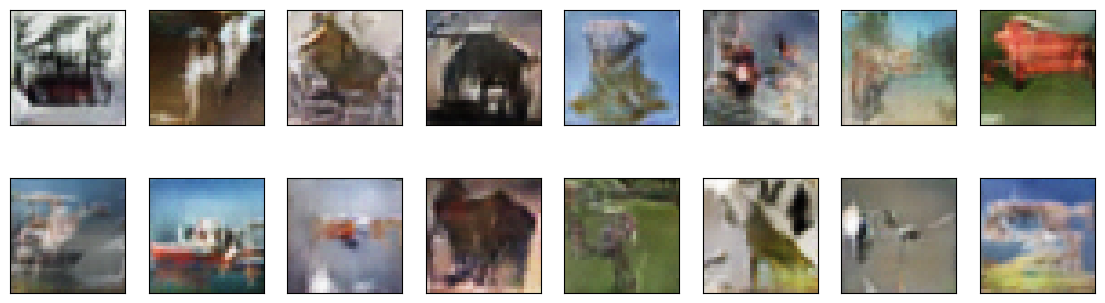

Epoch 4/30: 100%|██████████| 391/391 [00:15<00:00, 24.69it/s]


Epoch [4/30], D Loss: 0.4148, G Loss: 3.2866


Epoch 5/30: 100%|██████████| 391/391 [00:15<00:00, 24.67it/s]


Epoch [5/30], D Loss: 0.3527, G Loss: 5.6454


Epoch 6/30: 100%|██████████| 391/391 [00:15<00:00, 24.96it/s]


Epoch [6/30], D Loss: 0.3762, G Loss: 3.0948


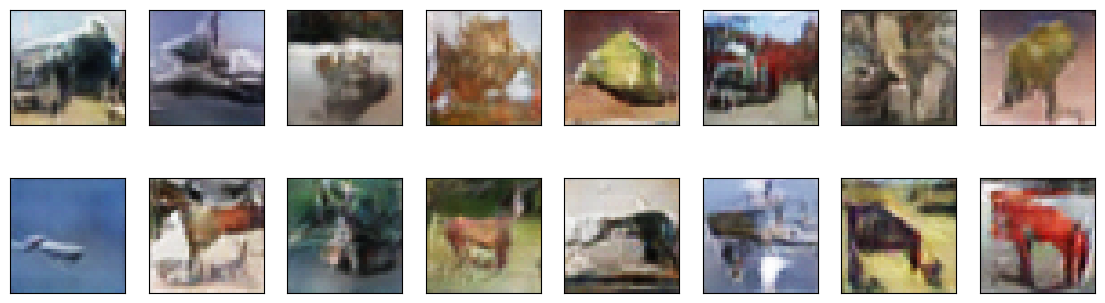

Epoch 7/30: 100%|██████████| 391/391 [00:15<00:00, 24.74it/s]


Epoch [7/30], D Loss: 0.4302, G Loss: 5.9445


Epoch 8/30: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s]


Epoch [8/30], D Loss: 0.4253, G Loss: 5.8212


Epoch 9/30: 100%|██████████| 391/391 [00:15<00:00, 24.82it/s]


Epoch [9/30], D Loss: 0.3579, G Loss: 5.4439


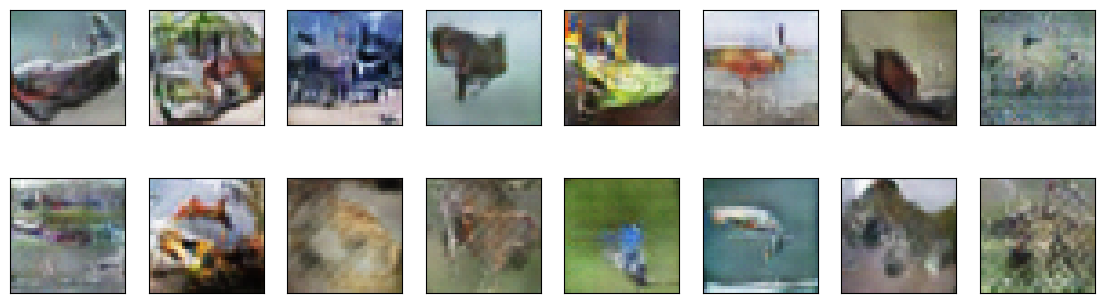

Epoch 10/30: 100%|██████████| 391/391 [00:15<00:00, 24.95it/s]


Epoch [10/30], D Loss: 1.0376, G Loss: 1.8417


Epoch 11/30: 100%|██████████| 391/391 [00:15<00:00, 24.56it/s]


Epoch [11/30], D Loss: 0.3828, G Loss: 4.8600


Epoch 12/30: 100%|██████████| 391/391 [00:16<00:00, 24.09it/s]


Epoch [12/30], D Loss: 0.3590, G Loss: 3.1678


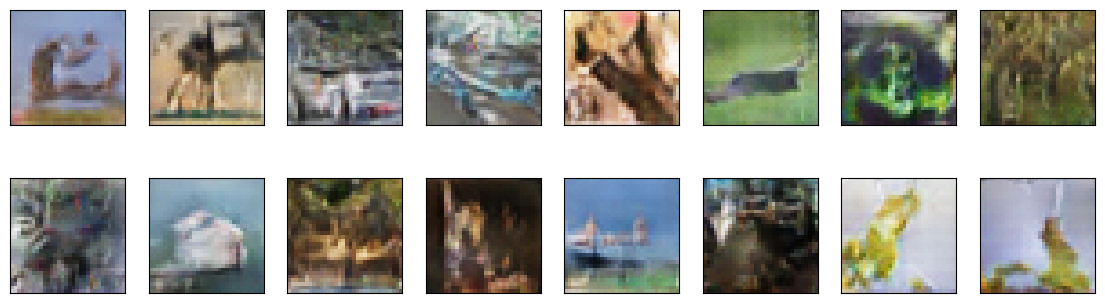

Epoch 13/30: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]


Epoch [13/30], D Loss: 0.3779, G Loss: 3.4772


Epoch 14/30: 100%|██████████| 391/391 [00:15<00:00, 24.51it/s]


Epoch [14/30], D Loss: 0.6747, G Loss: 1.6212


Epoch 15/30: 100%|██████████| 391/391 [00:16<00:00, 24.42it/s]


Epoch [15/30], D Loss: 0.3691, G Loss: 4.8961


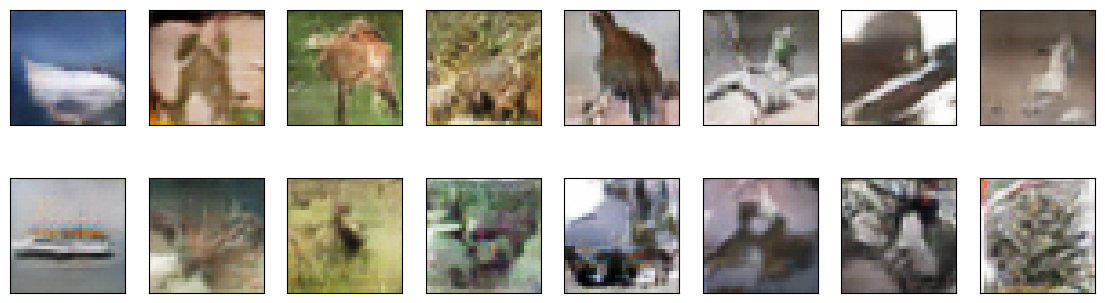

Epoch 16/30: 100%|██████████| 391/391 [00:16<00:00, 23.66it/s]


Epoch [16/30], D Loss: 0.5062, G Loss: 3.0778


Epoch 17/30: 100%|██████████| 391/391 [00:16<00:00, 23.26it/s]


Epoch [17/30], D Loss: 0.3601, G Loss: 4.4683


Epoch 18/30: 100%|██████████| 391/391 [00:16<00:00, 24.12it/s]


Epoch [18/30], D Loss: 0.3795, G Loss: 3.4223


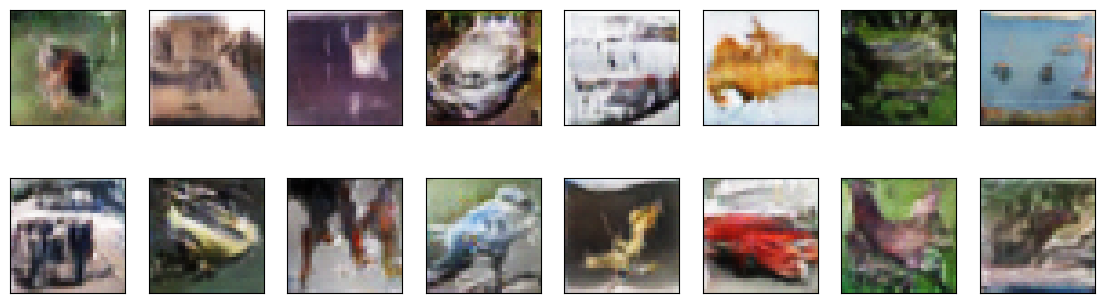

Epoch 19/30: 100%|██████████| 391/391 [00:16<00:00, 24.02it/s]


Epoch [19/30], D Loss: 0.5419, G Loss: 3.7131


Epoch 20/30: 100%|██████████| 391/391 [00:16<00:00, 23.93it/s]


Epoch [20/30], D Loss: 0.3788, G Loss: 5.1120


Epoch 21/30: 100%|██████████| 391/391 [00:17<00:00, 22.54it/s]


Epoch [21/30], D Loss: 0.3447, G Loss: 5.2507


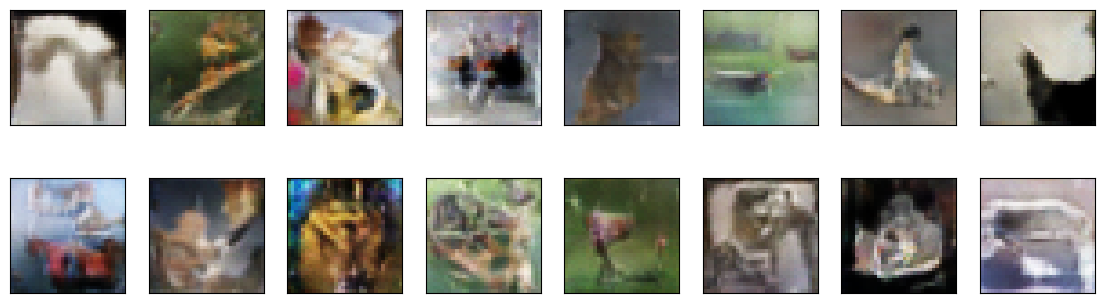

Epoch 22/30: 100%|██████████| 391/391 [00:16<00:00, 24.10it/s]


Epoch [22/30], D Loss: 0.3827, G Loss: 5.1798


Epoch 23/30: 100%|██████████| 391/391 [00:16<00:00, 24.13it/s]


Epoch [23/30], D Loss: 0.3744, G Loss: 4.3401


Epoch 24/30: 100%|██████████| 391/391 [00:16<00:00, 23.93it/s]


Epoch [24/30], D Loss: 0.3905, G Loss: 3.2552


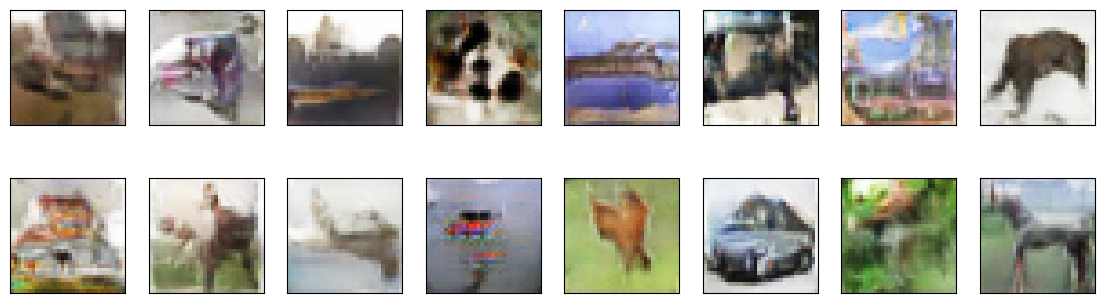

Epoch 25/30: 100%|██████████| 391/391 [00:17<00:00, 22.31it/s]


Epoch [25/30], D Loss: 0.5111, G Loss: 3.9479


Epoch 26/30: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]


Epoch [26/30], D Loss: 0.3937, G Loss: 5.3903


Epoch 27/30: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]


Epoch [27/30], D Loss: 0.3532, G Loss: 5.1231


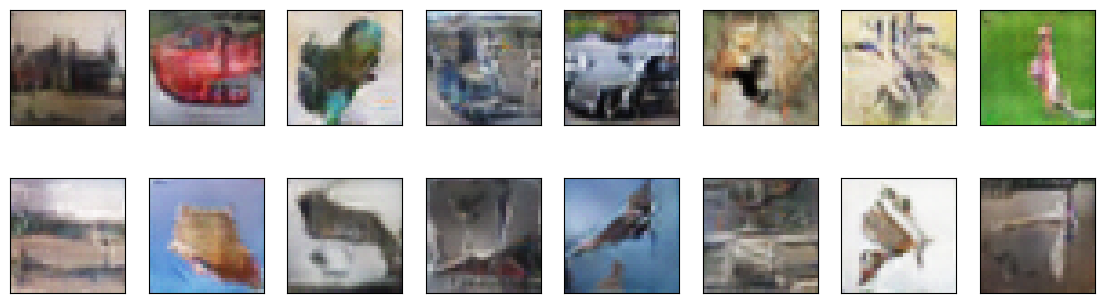

Epoch 28/30: 100%|██████████| 391/391 [00:16<00:00, 24.24it/s]


Epoch [28/30], D Loss: 0.3581, G Loss: 3.0284


Epoch 29/30: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s]


Epoch [29/30], D Loss: 0.3491, G Loss: 3.2520


Epoch 30/30: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]


Epoch [30/30], D Loss: 0.3952, G Loss: 4.1607


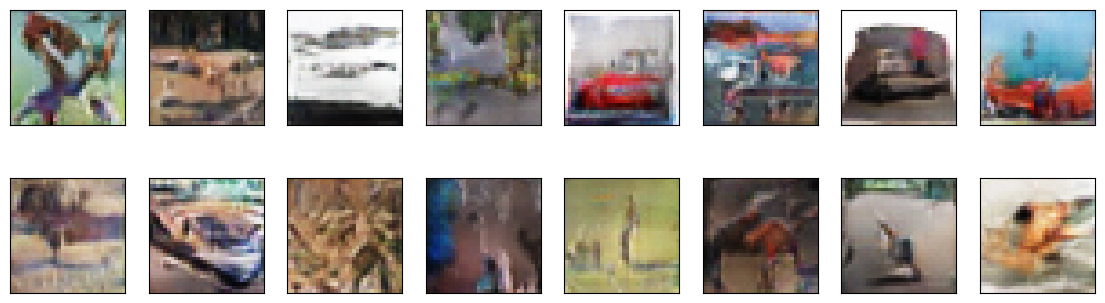

In [17]:
for epoch in range(num_epochs):
    for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_size = real_images.size(0)

        # Train the discriminator
        disc_loss = train_discriminator(real_images, discriminator, disc_optimizer,
                                        generator, latent_dim, gpu)

        # Train the generator
        gen_loss = train_generator(discriminator, generator, gen_optimizer, batch_size,
                                   latent_dim, gpu, channels=3)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"D Loss: {disc_loss:.4f}, G Loss: {gen_loss:.4f}")

    # Generate and view samples
    if (epoch + 1) % 3 == 0:  # Generate samples every 10 epochs to monitor progress
        samples = make_samples(generator, 16, latent_dim, channels=3, gpu=gpu)
        view_samples(samples)